# Association Analysis - 연관 분석

## 공통 코드

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "AssociationAnalysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
#이미지를 저장할 디렉토리 생성
os.makedirs(IMAGES_PATH, exist_ok=True)

#이미지를 저장할 때 사용하기 위한 함수
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from matplotlib import font_manager, rc
import platform

#한글 출력을 위한 부분
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

#음수 출력을 위한 부분
mpl.rcParams['axes.unicode_minus'] = False

# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한 
%precision 3

#그래픽 출력을 조금 더 고급화하기 위한 라이브러리
import seaborn as sns

#과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats

# 사이킷런 ≥0.20 필수: 0.20 에서 데이터 변환을 위한 Transformer 클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경이 되서 훈령용 데이터가
# 자주 변경되면 결국 모든 데이터를 가지고 모델을 생성하는 결과
# Overfit이 될 가능성이 높아짐
np.random.seed(42)

In [185]:
#데이터 가져오기
movies = pd.read_csv("./data/movielens/movies.csv")
ratings = pd.read_csv("./data/movielens/ratings.csv")
#movies.info()
#ratings.info()
ratings = ratings[['userId', 'movieId', 'rating']]
#ratings.info()

#영화 제목 과 점수를 하나의 테이블로 만들기 위해서 조인
rating_movies = pd.merge(ratings, movies, on = 'movieId')
#rating_movies.info()

#index를 userId 로 title을 컬럼으로 rating을 계산 항목으로 해서 테이블을 수정
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')
print(ratings_matrix.head())

title   '71 (2014)  'Hellboy': The Seeds of Creation (2004)  \
userId                                                        
1              NaN                                      NaN   
2              NaN                                      NaN   
3              NaN                                      NaN   
4              NaN                                      NaN   
5              NaN                                      NaN   

title   'Round Midnight (1986)  'Salem's Lot (2004)  \
userId                                                
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          NaN                  NaN   
4                          NaN                  NaN   
5                          NaN                  NaN   

title   'Til There Was You (1997)  'Tis the Season for Love (2015)  \
userId                                                               
1                             Na

In [186]:
#행렬 분해 수행
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=2000,
                            learning_rate=0.01, r_lambda=0.01)
#분해 한 행렬을 가지고 복원
pred_matrix = np.dot(P, Q.T)

iteration step: 0 rmse: 2.90232818555189
iteration step: 10 rmse: 0.7351113862958799
iteration step: 20 rmse: 0.5123898662284837
iteration step: 30 rmse: 0.3721250233402941
iteration step: 40 rmse: 0.29488159318033147
iteration step: 50 rmse: 0.25069016190815696
iteration step: 60 rmse: 0.22359281108016085
iteration step: 70 rmse: 0.20569395296079368
iteration step: 80 rmse: 0.19309650533737674
iteration step: 90 rmse: 0.18377354348810146
iteration step: 100 rmse: 0.17659839467575372
iteration step: 110 rmse: 0.17090458843379333
iteration step: 120 rmse: 0.16627563433399425


KeyboardInterrupt: 

In [ ]:
print(pred_matrix)

In [ ]:
#행렬 분해를 한 후 복원한 결과를 DataFrame으로 변환
ratings_pred_matrix = pd.DataFrame(data = pred_matrix, index=ratings_matrix.index,
                                  columns = ratings_matrix.columns)
print(ratings_pred_matrix.head())

In [ ]:
#영화를 보지 않은 목록을 리턴하는 함수 - 영화의 경우는 일반적으로 본 영화를 추천하지 않음
def get_unseen_movies(ratings_matrix, userId):
    user_rating = ratings_matrix.loc[userId, :]
    #평점이 0을 초과한 데이터는 이미 본 영화
    already_seen = user_rating[user_rating > 0].index.tolist()
    movies_list = ratings_matrix.columns.tolist()
    unseen_list = [movie for movie in movies_list if movie not in already_seen]
    
    return unseen_list


In [ ]:
#보지 않은 영화중에서 평점이 높은 순으로 정렬해서 리턴
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [ ]:
#9번 유저가 보지 않은 영화목록 만들기
unseen_list = get_unseen_movies(ratings_matrix, 9)
#보지 않은 영화중에서 예측 평점이 높은 영화 목록 만들기
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)
print(recomm_movies)

## surprise 패키지 활용

In [ ]:
!pip install scikit-surprise

In [187]:
import surprise
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

data = Dataset.load_builtin(name='ml-1m', prompt=True)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


In [188]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)
print(type(trainset))
print(type(testset))

<class 'surprise.trainset.Trainset'>
<class 'list'>


In [189]:
algo = SVD()
algo.fit(trainset)

In [190]:
predictions = algo.test(testset)
#print(predictions[:5])

print([(pred.uid, pred.iid, pred.est) for pred in predictions[:5]])

[('1263', '539', 2.752905508710765), ('975', '1619', 3.4279127329665253), ('3929', '1196', 4.779026117801598), ('1839', '10', 4.345049697383132), ('1499', '3952', 4.133249808543489)]


In [191]:
uid = str(1263)
iid = str(539)

pred = algo.predict(uid, iid)
print(pred)

user: 1263       item: 539        r_ui = None   est = 2.75   {'was_impossible': False}


## 로컬 데이터를 이용한 surprise 패키지 활용


In [192]:
#현재 로컬 데이터는 헤더에 컬럼 이름이 있고 userid, movieid, rating, timestamp 컬럼으로 구성되어 있음
from surprise import Reader
ratings = pd.read_csv('./data/movielens/ratings.csv')
#print(ratings.head())
#구조 변경을 위해서 헤더를 제외하고 파일로 저장
ratings.to_csv('./data/movielens/ratings_noh.csv', index=False, header=False)
ratings = pd.read_csv('./data/movielens/ratings_noh.csv')
print(ratings.head())

   1  1.1  4.0  964982703
0  1    3  4.0  964981247
1  1    6  4.0  964982224
2  1   47  5.0  964983815
3  1   50  5.0  964982931
4  1   70  3.0  964982400


In [193]:
reader = Reader(line_format=' user item rating timestamp', sep=',', 
               rating_scale=(0.5, 5))
data = Dataset.load_from_file('./data/movielens/ratings_noh.csv', reader=reader)

In [194]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)
algo = SVD(n_factors=50, random_state=42)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8785


0.878

In [195]:
#교차 검증
from surprise.model_selection import cross_validate

ratings = pd.read_csv('./data/movielens/ratings.csv')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=42)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8782  0.8761  0.8610  0.8767  0.8719  0.8728  0.0063  
MAE (testset)     0.6766  0.6748  0.6610  0.6710  0.6690  0.6705  0.0055  
Fit time          1.38    1.40    1.39    1.45    1.36    1.40    0.03    
Test time         0.12    0.12    0.12    0.15    0.13    0.13    0.01    


{'test_rmse': array([0.878, 0.876, 0.861, 0.877, 0.872]),
 'test_mae': array([0.677, 0.675, 0.661, 0.671, 0.669]),
 'fit_time': (1.380, 1.402, 1.390, 1.447, 1.363),
 'test_time': (0.121, 0.125, 0.124, 0.154, 0.134)}

In [196]:
# 하이퍼파라미터 튜닝 - 입력하는 파라미터의 최적값을 찾는 작업
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [20, 40, 60], 'n_factors':[50, 100, 200]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
print(gs.best_score['rmse'])

0.8786816125518234


In [197]:
print(gs.best_params['rmse'])

{'n_epochs': 20, 'n_factors': 50}


## 상품 추천

In [198]:
df = pd.read_csv('./data/online_retail.csv', encoding='ISO-8859-1',
                dtype={'InvoiceID': str, 'CustomerID': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [199]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [201]:
#결측치 확인
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [202]:
df = df.dropna()
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [203]:
#수량이 0보다 작거나 같은 데이터 제거
print((df['Quantity'] <= 0).sum())
df = df[df['Quantity'] > 0]
print((df['Quantity'] <= 0).sum())

8905
0


In [204]:
#가격이 0보다 작거나 같은 데이터 제거
print((df['UnitPrice'] <= 0).sum())
df = df[df['UnitPrice'] > 0]
print((df['UnitPrice'] <= 0).sum())

40
0


In [205]:
#상품 코드가 잘못 입력된 경우 제거 - 상품 코드는 숫자로만 구성
df['ContainDigit'] = df['StockCode'].apply(lambda x : any(c.isdigit() for c in x))
print(df[df['ContainDigit'] == False].sum())
df = df[df['ContainDigit'] == True]

InvoiceNo       5363705364035365275365695365695367795368405368...
StockCode       POSTPOSTPOSTMMBANK CHARGESPOSTPOSTPOSTPOSTPOST...
Description     POSTAGEPOSTAGEPOSTAGEManualManualBank ChargesP...
Quantity                                                    10324
UnitPrice                                               96550.134
CustomerID      1258312791126621627416274158231273812686135201...
Country         FranceNetherlandsGermanyUnited KingdomUnited K...
ContainDigit                                                    0
dtype: object


C:\Users\USER\AppData\Local\Temp\ipykernel_4628\1820475976.py:3: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df[df['ContainDigit'] == False].sum())


<Axes: xlabel='InvoiceDate'>

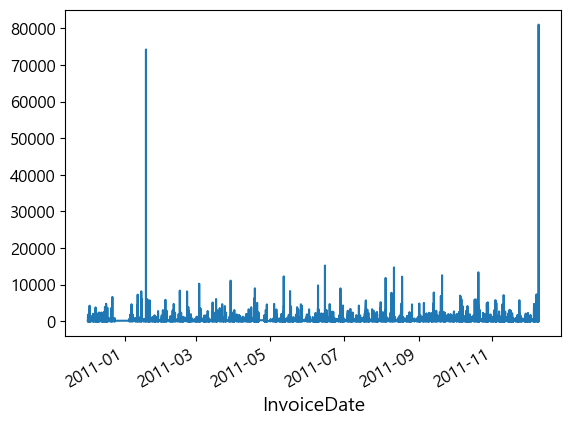

In [206]:
#일자별 거래 수량을 확인
data_quantity_series = df.groupby('InvoiceDate')['Quantity'].sum()
data_quantity_series.plot()

<Axes: xlabel='InvoiceDate'>

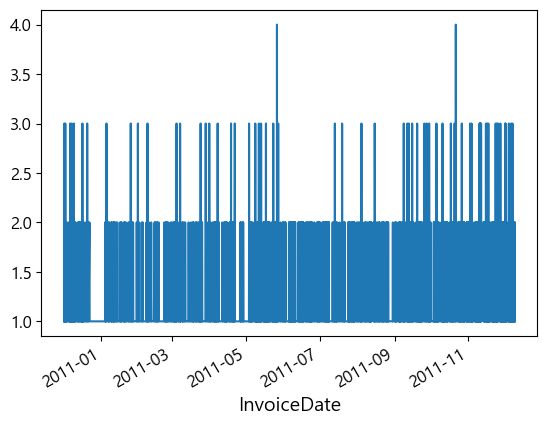

In [207]:
#일자별 거래 수량을 확인
data_transaction_series = df.groupby('InvoiceDate')['InvoiceNo'].nunique()
data_transaction_series.plot()

<Axes: xlabel='InvoiceDate'>

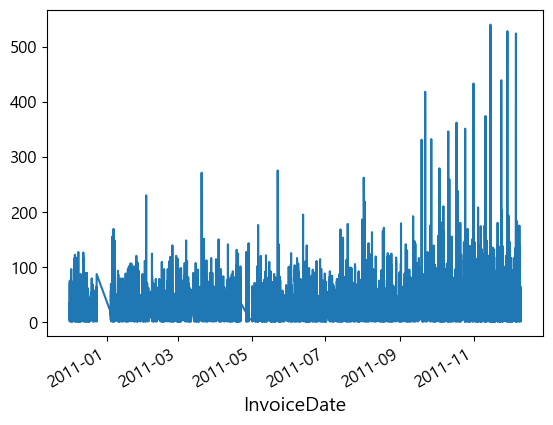

In [208]:
#일자별 거래 수량을 확인
data_unique_item_series = df.groupby('InvoiceDate')['StockCode'].nunique()
data_unique_item_series.plot()

<Axes: xlabel='date'>

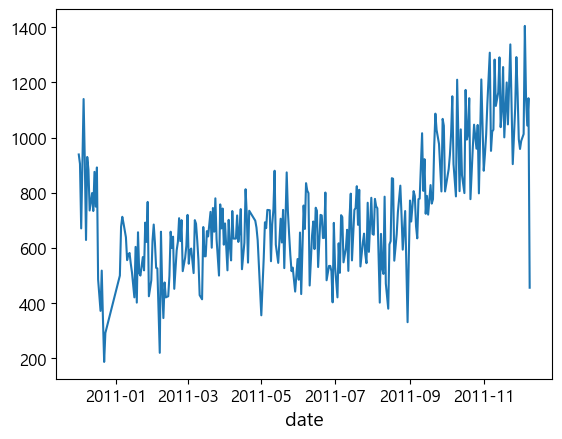

In [209]:
#일자별 거래 수량을 확인
df['date'] = df['InvoiceDate'].dt.date
data_unique_item_series = df.groupby('date')['StockCode'].nunique()
data_unique_item_series.plot()

In [210]:
print(df['date'].min())
print(df['date'].max())


2010-12-01
2011-12-09


<Axes: xlabel='date'>

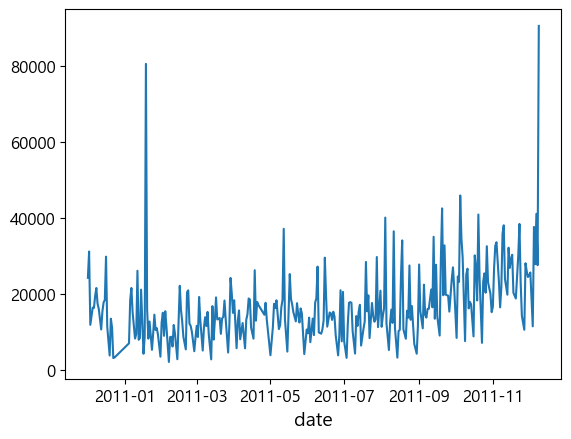

In [211]:
#날짜 별로 거래 수량의 합을 확인
date_quantity_series = df.groupby('date')['Quantity'].sum()
date_quantity_series.plot()

<Axes: xlabel='date'>

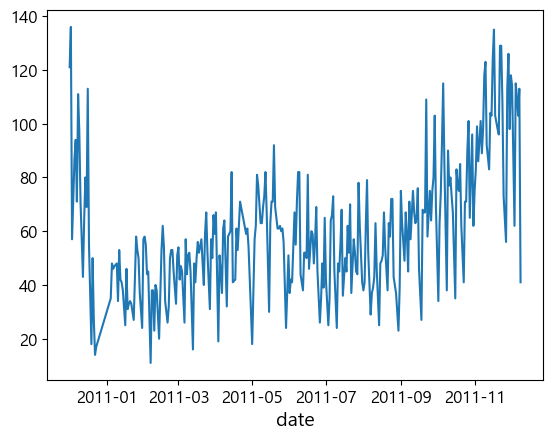

In [212]:
#날짜 별로 거래 횟수를 확인
date_transaction_series = df.groupby('date')['InvoiceNo'].nunique()
date_transaction_series.plot()

In [213]:
#유저 별 거래 횟수를 탐색
customer_unique_transaction_series = df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_unique_transaction_series.describe()

count    4334.000000
mean        4.246654
std         7.642535
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       206.000000
Name: InvoiceNo, dtype: float64

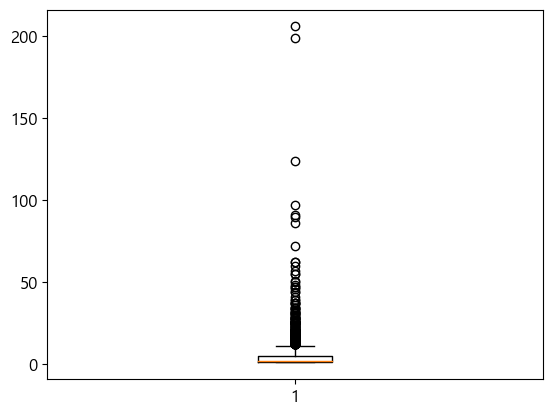

In [214]:
plt.boxplot(customer_unique_transaction_series.values)
plt.show()

In [215]:
#유저 별 아이템 종류 개수를 탐색
customer_unique_item_series = df.groupby('CustomerID')['StockCode'].nunique()
customer_unique_item_series.describe()

count    4334.000000
mean       61.432856
std        85.312937
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1786.000000
Name: StockCode, dtype: float64

In [216]:
#거래가 가장 많은 상품 TOP 10 탐색
df.groupby('StockCode')['InvoiceNo'].nunique().sort_values(ascending=False)[:10]

StockCode
85123A    1978
22423     1703
85099B    1600
47566     1379
84879     1375
20725     1289
22720     1146
23203     1080
20727     1052
22383     1043
Name: InvoiceNo, dtype: int64

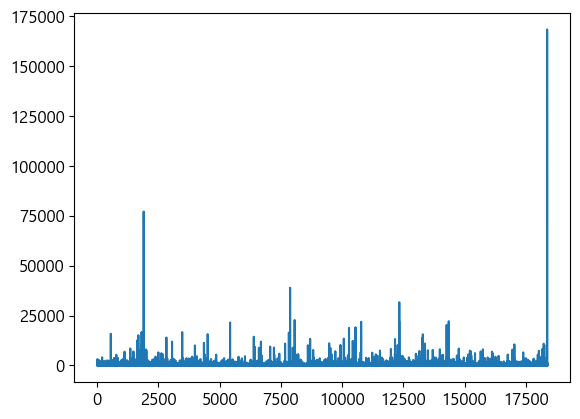

In [217]:
#파생 변수 생성 - 다른 속성을 가지고 계산이 가능한 필드를 추가
#관계형 데이터베이스 모델링에서는 이런 필드를 생성하지 말라고 하지만
#Customizing 과정에서는 자주 사용된다면 미리 만들어두는 것이 효율이 좋다라고 합니다.
df['amount'] = df['Quantity'] * df['UnitPrice']
plt.plot(df.groupby('InvoiceNo')['amount'].sum().values)

In [218]:
#데이터를 특정 시점으로 분리 - 2011년 11월 1일을 기준으로 분리
import datetime

df_year_round = df[df['date'] < datetime.date(2011, 11, 1)]
df_year_end = df[df['date'] >= datetime.date(2011, 11, 1)]
print(df_year_round.head())
print(df_year_end.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  ContainDigit  \
0 2010-12-01 08:26:00       2.55      17850  United Kingdom          True   
1 2010-12-01 08:26:00       3.39      17850  United Kingdom          True   
2 2010-12-01 08:26:00       2.75      17850  United Kingdom          True   
3 2010-12-01 08:26:00       3.39      17850  United Kingdom          True   
4 2010-12-01 08:26:00       3.39      17850  United Kingdom          True   

         date  amount  
0  2010-12-01   15.30  
1  2010-12-01   20.34  
2  2010-12-01   22.00  
3  2010-

In [219]:
#11월 이전 데이터에서 고객 아이디 별로 상품 ID를 하나씩만 존재하도록 수정
customer_item_round_set = df_year_round.groupby('CustomerID')['StockCode'].apply(set)
print(customer_item_round_set)

CustomerID
12346                                              {23166}
12347    {20719, 47580, 23421, 22492, 23308, 23146, 849...
12348    {22616, 22952, 84991, 23078, 21213, 21211, 230...
12350    {22348, 79066K, 22412, 22557, 21908, 22620, 21...
12352    {22413, 22635, 22645, 22064, 22701, 37448, 227...
                               ...                        
18280    {22727, 22180, 82484, 22467, 22499, 22725, 220...
18281    {23209, 22028, 23007, 22467, 22037, 22716, 23008}
18282    {21270, 22424, 21109, 23295, 21108, 22089, 23187}
18283    {22644, 82581, 21231, 22663, 22383, 20728, 207...
18287    {22866, 22644, 72351B, 22114, 85039B, 20963, 8...
Name: StockCode, Length: 3970, dtype: object


In [220]:
#11월 이전에 구매한 상품 코드를 이후에 구매한 상품 코드 와 구분을 하기 위해서 old를 추가
#고객 아이디별로 구매한 상품을 디셔너리로 만들 것인데 예전에 산 항목을 구분하기 위해서
#old를 값으로 추가

customer_item_dict = {}
for customer_id, stocks in customer_item_round_set.items():
    customer_item_dict[customer_id] = {}
    for stock in stocks:
        customer_item_dict[customer_id][stock] = 'old'
#데이터가 너무 많아서 한 번에 출력이 안되므로 데이터를 문자열로 변경해서 인덱싱 한 후 출력
print(str(customer_item_dict)[:100])

{'12346': {'23166': 'old'}, '12347': {'20719': 'old', '47580': 'old', '23421': 'old', '22492': 'old'


In [221]:
#11월 이후에 구매한 상품의 중복을 제거
customer_item_end_set = df_year_end.groupby('CustomerID')['StockCode'].apply(set)
#print(customer_item_end_set)

#11월 이전에만 구매한 상품은 old 11월 이후에만 구매한 상품은 new
#양쪽 다 구매한 것이면 both - 주기를 파악할 필요가 있습니다
for customer_id, stocks in customer_item_end_set.items():
    #customer_item_dict는 customer_id를 key로 가지고 구매한 상품을 dict로 가지고 있음
    #이 경우는 이전에 구매한 상품인지 확인이 필요
    if customer_id in customer_item_dict:
        for stock in stocks:
            if stock in customer_item_dict[customer_id]:
                customer_item_dict[customer_id][stock] = 'both'
            else:
                customer_item_dict[customer_id][stock] = 'new'
    
    #이 경우는 이전에 구매한 상품인지 확인할 필요가 없습니다.
    else:
        customer_item_dict[customer_id] = {}
        for stock in stocks:
            customer_item_dict[customer_id][stock] = 'new'

print(str(customer_item_dict)[:100])








{'12346': {'23166': 'old'}, '12347': {'20719': 'both', '47580': 'old', '23421': 'old', '22492': 'old


In [222]:
#고객 별로 old 와 new 와 both의 개수를 파악
columns = ['CustomerID', 'old', 'new', 'both']
df_order_info = pd.DataFrame(columns=columns)
for customer_id in customer_item_dict:
    old = 0
    new = 0
    both = 0
    
    for stock_code in customer_item_dict[customer_id]:
        status = customer_item_dict[customer_id][stock_code]
        if status == 'old':
            old = old + 1
        elif status == 'new':
            new = new + 1
        else:
            both = both + 1
            
    #DataFrame에 개수를 추가
    row = [customer_id, old, new, both]
    series = pd.Series(row, index=columns)
    df_order_info = df_order_info.append(series, ignore_index=True)

    

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_info = df_order_info.append(series, ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_4628\416941206.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order

In [223]:
print(df_order_info.head())

  CustomerID old new both
0      12346   1   0    0
1      12347  92   3    8
2      12348  21   0    0
3      12350  16   0    0
4      12352  43  12    2


In [224]:
#전체 유저 수
print(df_order_info.shape[0])

#11월 이후에 새로운 상품을 구매한 유저 수
print(df_order_info[(df_order_info['old'] > 0) & (df_order_info['new'] > 0)].shape[0])

#동일한 제품을 재구매한 고객 수 - 이 고객들은 구매 주기를 확인해볼 필요가 있음
#식료품이라면 미리 알림을 주는 것도 좋은 마케팅 방법 중 하나
#동일한 식료품이지만 품질이 더 좋거나 싼 제품을 추천하기도 함
print(df_order_info[df_order_info['both'] > 0].shape[0])

4334
1446
1426


In [225]:
#11월 이후에 어떤 상품을 새로 구매를 많이 했는지 확인
#각 년도별 월 단위도 체크를 해야 합니다.
#이전 몇 개월 동안 구매하지 않다가 특정 월 이후에 구매하는 경우는 계절성 상품
df_order_info['new'].value_counts()

0      2521
1        81
3        73
2        72
8        65
       ... 
116       1
157       1
124       1
130       1
99        1
Name: new, Length: 133, dtype: int64

In [226]:
#유저의 수 와 상품의 수 파악
print(len(df_year_round['CustomerID'].unique()))
print(len(df_year_round['StockCode'].unique()))

3970
3608


In [227]:
#추천 시스템을 만들 때는 유저 와 상품 그리고 평점이 존재해야 합니다.
#소핑몰에서는 평점 대신에 구매 횟수를 사용하기도 합니다.
uir_df = df_year_round.groupby(['CustomerID', 'StockCode'])['InvoiceNo'].nunique().reset_index()
print(uir_df.head())

  CustomerID StockCode  InvoiceNo
0      12346     23166          1
1      12347     16008          1
2      12347     17021          1
3      12347     20665          1
4      12347     20719          3


array([[<Axes: title={'center': 'InvoiceNo'}>]], dtype=object)

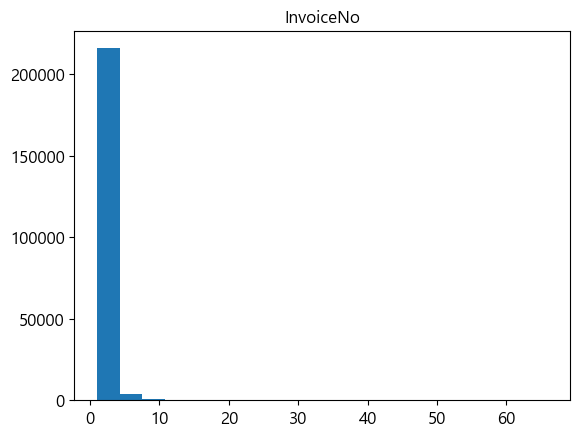

In [228]:
#분포 확인 - 구매는 1번이 경우가 아주 많음
#예측을 할 때 타겟은 정규 분포인 경우가 가장 잘 하게 됩니다.
#타겟값의 편차가 너무 크거나 한쪽에 쏠린 경우 로그 변환 등을 수행
uir_df.hist(bins=20, grid=False)

<Axes: >

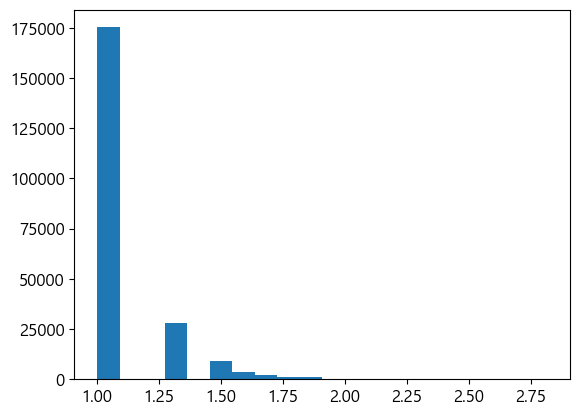

In [229]:
#로그 변환 수행
uir_df['InvoiceNo'].apply(lambda x:np.log10(x) + 1).hist(bins=20, grid=False)

In [230]:
uir_df['Rating'] = uir_df['InvoiceNo'].apply(lambda x:np.log10(x) + 1)
uir_df['Rating'] = ((uir_df['Rating'] - uir_df['Rating'].min()) / (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1


In [231]:
#추천 알고리즘이 사용할 데이터 생성
uir_df = uir_df[['CustomerID', 'StockCode', 'Rating']]
print(uir_df.head())

  CustomerID StockCode    Rating
0      12346     23166  1.000000
1      12347     16008  1.000000
2      12347     17021  1.000000
3      12347     20665  1.000000
4      12347     20719  2.048881


In [233]:
import time
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

In [237]:
train_start = time.time()
#n_factors는 요인의 수로 기본값은 100
#lr_all은 학습률
#reg_all: 정규화 항으로 클수록 파라미터를 작게 추정하는데 기본값은 0.02
#n_epochs: 수행 횟수
model = SVD(n_factors=8, lr_all=0.005, reg_all=0.02, n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("훈련 시간:", (train_end - train_start))

훈련 시간: 11.658727407455444


In [238]:
predictions = model.test(test_data)
print(accuracy.rmse(predictions))

RMSE: 0.3357
0.33574003641989775


[Prediction(uid='15298', iid='22645', r_ui=1.0, est=1.4130916188844709, details={'was_impossible': F


In [242]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(uir_df[['CustomerID', 'StockCode', 'Rating']], reader)
#전체 데이터를 가지고 훈련
train_data = data.build_full_trainset()
train_start = time.time()
#n_factors는 요인의 수로 기본값은 100
#lr_all은 학습률
#reg_all: 정규화 항으로 클수록 파라미터를 작게 추정하는데 기본값은 0.02
#n_epochs: 수행 횟수
model = SVD(n_factors=8, lr_all=0.005, reg_all=0.02, n_epochs=200)
model.fit(train_data)
train_end = time.time()
print("훈련 시간:", (train_end - train_start))

훈련 시간: 6.179501295089722


In [243]:
#이전에 구매하지 않았던 항목을 가지고 예측
test_data = train_data.build_anti_testset()
target_user_predictions = model.test(test_data)
print(target_user_predictions)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [244]:
#구매 예측 결과를 디셔너리로 변환해서 보기 좋게 출력
new_order_prediction_dict = {}
for customer_id, stock_code , _, predicted_rating, _ in target_user_predictions:
    if customer_id in new_order_prediction_dict:
        if stock_code in new_order_prediction_dict[customer_id]:
            pass
        else:
            new_order_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        new_order_prediction_dict[customer_id] = {}
        new_order_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(new_order_prediction_dict)[:300] + "...")

{'12346': {'16008': 1, '17021': 1.2250084255426996, '20665': 1.0416122257187341, '20719': 1.337540274675815, '20780': 1.0408033220959783, '20782': 1.1571596861690114, '20966': 1.044371528575423, '21035': 1.0788301467921317, '21041': 1.0405440820235077, '21064': 1.1959246467038178, '21154': 1.1037006...


In [245]:
#이전에 구매했던 항목을 가지고 예측
test_data = train_data.build_testset()
target_user_predictions = model.test(test_data)
#print(target_user_predictions)

#구매 예측 결과를 디셔너리로 변환해서 보기 좋게 출력
reorder_prediction_dict = {}
for customer_id, stock_code , _, predicted_rating, _ in target_user_predictions:
    if customer_id in reorder_prediction_dict:
        if stock_code in reorder_prediction_dict[customer_id]:
            pass
        else:
            reorder_prediction_dict[customer_id][stock_code] = predicted_rating
    else:
        reorder_prediction_dict[customer_id] = {}
        reorder_prediction_dict[customer_id][stock_code] = predicted_rating
        
print(str(reorder_prediction_dict)[:300] + "...")

{'12346': {'23166': 1.028802717634506}, '12347': {'16008': 1.0167919001852874, '17021': 1.2184587331380794, '20665': 1.1412044322191808, '20719': 1.7355655470181732, '20780': 1.293138420919368, '20782': 1.3522151950231311, '20966': 1.472260775208959, '21035': 1.3733336580989655, '21041': 1.421604904...
